In [6]:
%run ~/ag1000g/selective_sweeps/scripts/sweep_tools.py

In [163]:
from pysam import count_coverage

ImportError: cannot import name 'count_coverage' from 'pysam' (/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/pysam/__init__.py)

In [64]:
def meanPBS(ac1, ac2, ac3, window_size, normalise):
    #pbs per variant
    pbs = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normalise)
    #get average of all pbs values (will be per gene)
    meanpbs = np.nanmean(pbs)
    
    _, se, stats = allel.stats.misc.jackknife(pbs, statistic=lambda n: np.mean(n))
    
    return(meanpbs, se, pbs, stats)

def flip_dict(dict_):
    flipped = defaultdict(dict)
    for key, val in dict_.items():
        for subkey, subval in val.items():
            flipped[subkey][key] = subval
    return(flipped)

def readAndFilterVcf(path, chrom, qualflt=30, missingfltprop=0.6, plot=True):
    
    print("-------------- Reading VCF --------------")
    vcf = allel.read_vcf(path, 
                      numbers=numbers,
                     fields=['calldata/*', 'variants/*', 'samples'])
    
    #get sample names and indices
    samplenames = vcf['samples']
    samplenames = pd.Series(samplenames).str.replace("\d", "")
    subpops = dict(list_duplicates(samplenames))
    print(subpops, "\n")
    
    print(f"------- Filtering VCF at QUAL={qualflt} and missingness proportion of {missingfltprop} -------")
    #apply quality filters
    qual = vcf['variants/QUAL']
    passfilter = (qual >= qualflt)
    geno = allel.GenotypeArray(vcf['calldata/GT'].compress(passfilter, axis=0))
    pos = allel.SortedIndex(vcf['variants/POS'].compress(passfilter, axis=0))
    depth = vcf['variants/DP'].compress(passfilter, axis=0)
    print(f"{passfilter.sum()} SNPs retained out of {passfilter.shape[0]} for chromosome {chrom}")
    
    #plot hitogram of QUAL values
    if plot is True:
        print("Plotting histogram of QUAL scores, with extreme outliers removed")
        fltqual = qual[~is_outlier(qual)]
        plt = sns.distplot(fltqual)
        plt.figure.savefig(f"../../results/variants/qc/qual.{chrom}.hist.png")
    
    #missingness filters 
    ac = geno.count_alleles()
    snpcounts = ac.sum(axis=1)
    missingflt = snpcounts.max()*missingfltprop # must have at least 2/3rds alleles present
    missingness_flt = snpcounts > missingflt
    geno = geno.compress(missingness_flt, axis=0)
    pos = pos[missingness_flt]
    print(f"{missingness_flt.sum()} SNPs retained out of {missingness_flt.shape[0]} for chromosome {chrom}")
    
    #extract snpeff info and filter   
    snpeff = pd.DataFrame(vcf['variants/ANN'])[0].str.split("|", expand=True)[passfilter][missingness_flt]
    
    ac_subpops = geno.count_alleles_subpops(subpops)
    
    return(vcf, geno, ac_subpops, pos, depth, snpeff, subpops)

### Fst/PBS analysis on RNA-Seq data - Freebayes ploidy X

Here, I want to do a gene-based FST and gene-based PBS analysis, between treatment groups. Comparisons have been stored in the file data/DE.comparison.list.

In [33]:
comparisons = pd.read_csv("../../resources/DE.comparison.list", header=None)
comparisons.columns = ['contrast']
comparisons = comparisons.contrast.str.split("_", expand=True)
comparisons.columns = ['sus', 'res']

comparisons = [list(row) for i,row in comparisons.iterrows()]
print(f"The pairwise comparisons for Fst are {comparisons}")

The pairwise comparisons for Fst are [['ContAngola', 'FenAngola'], ['NewOrleans', 'ContAngola'], ['Rockefeller', 'ContAngola']]


In [34]:
samples = pd.read_csv("../../config/samples.tsv", sep="\t")
gffpath = "../../resources/reference/VectorBase-48_AaegyptiLVP_AGWG.gff"
pbs = True
chrom = 1
ploidy = 10 # args.ploidy

In [71]:
pbscomps = [['FenAngola', 'ContAngola', 'NewOrleans']] #args.pbsgroups 

numbers = {
    'samples':1,
    'variants/CHROM': 1,
    'variants/POS': 1,
    'variants/ID': 1,
    'variants/REF': 1,
    'variants/ALT': 'A',
    'variants/QUAL': 1,
    'variants/DP': 1,
    'variants/AN': 1,
    'variants/AC': 'A',
    'variants/AF': 'A',
    'variants/MQ': 1,
    'variants/ANN': 1,
    'calldata/DP': 1,
    'calldata/GT': ploidy,
    'calldata/GQ': 1,
    'calldata/HQ': 2,
    'calldata/AD': 'R',
    'calldata/MQ0': 1,
    'calldata/MQ': 1,
}

Lets load the GFF file

In [36]:
features = allel.gff3_to_dataframe(gffpath,
                       attributes=["ID"])
genes = features[features.type == 'gene']
genes = genes[genes.seqid == f"AaegL5_{chrom}"].sort_values('start').reset_index(drop=True)
genes.head()

,seqid,source,type,start,end,score,strand,phase,ID
0,AaegL5_1,VEuPathDB,gene,28171,28857,-1,-,-1,AAEL020532
1,AaegL5_1,VEuPathDB,gene,29507,30127,-1,-,-1,AAEL027741
2,AaegL5_1,VEuPathDB,gene,31440,34003,-1,+,-1,AAEL012102
3,AaegL5_1,VEuPathDB,gene,40655,104063,-1,-,-1,AAEL012106
4,AaegL5_1,VEuPathDB,gene,104142,105807,-1,-,-1,AAEL012094


#### Load VCFs and extract arrays

Lets load our VCF and annotation data, and store what we need in easy to reach variables.

-------------- Reading VCF --------------
{'FenAngola': [0, 7, 10], 'NewOrleans': [1, 8, 11], 'ContAngola': [2, 4, 5], 'Rockefeller': [3, 6, 9]} 

------- Filtering VCF at QUAL=30 and missingness proportion of 0.6 -------
568812 SNPs retained out of 743586 for chromosome 1
Plotting histogram of QUAL scores, with extreme outliers removed
313624 SNPs retained out of 568812 for chromosome 1


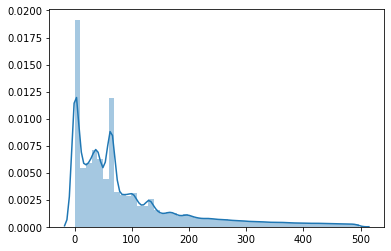

In [51]:
path = f"../../results/variants/annot.variants.{chrom}.vcf"

vcf, geno, acsubpops, pos, depth, snpeff, subpops =  readAndFilterVcf(path=path, 
                                                           chrom=chrom, 
                                                           qualflt=30, 
                                                           plot=True)

In [52]:
#dict((k, sampleIndices[k]) for k in ('FenAngola', 'ContAngola'))
#res, sus = list(comparison.values())
#res_gn = geno.take(res, axis=1)
#sus_gn = geno.take(sus, axis=1)
#sus_ac = allel.GenotypeArray(sus_gn).count_alleles()
#res_ac = allel.GenotypeArray(res_gn).count_alleles()
#gn_comparison = np.concatenate([res_gn, sus_gn], axis=1)
#indices = [np.arange(15), np.arange(15, 30)]

### Average Fst, pbs, tajima d for each gene 

In [53]:
for comp1, comp2 in comparisons:
    print(comp1 + "_" +comp2)

ContAngola_FenAngola
NewOrleans_ContAngola
Rockefeller_ContAngola


In [82]:
fst_per_comp = dict()
fst_per_gene = dict()
pbs_per_gene = dict()
pbs_per_comp = dict()
tajd_per_pop = dict()
tajd_per_gene = dict()
gdiv_per_pop = dict()
gdiv_per_gene = dict()
se_dict = dict()
pos_dict = dict()
n_dict = dict()


for i, gene in genes.iterrows():
    ID = gene.ID
    #locate_ranges() to get a boolean, needed as locate_range() will throw errors if no snps found in gene
    gene_bool = pos.locate_ranges([gene['start']], [gene['end']], strict=False)
    nsnps = gene_bool.sum()
    
    #if there are less than 3 snps in this gene then skip to next in loop
    if nsnps < 3:
        continue
        
    #store number of snps per gene
    n_dict[ID] = nsnps
    #store midpoint positions of gene
    pos_dict[ID] = (gene['start'] + gene['end'])/2
    
    #fst per gene between each comparison
    for comp1,comp2 in comparisons:
        name = comp1 + "_" + comp2
        ac1 = acsubpops[comp1].compress(gene_bool, axis=0)
        ac2 = acsubpops[comp2].compress(gene_bool, axis=0)
        
        fst_per_comp[name], se_dict[name],_,_= allel.average_hudson_fst(ac1, ac2, blen=1)   
        
    #tajimas d and sequence diversity per gene for each subpop(i.e treatment)
    for subpop in subpops:
        ac = acsubpops[subpop].compress(gene_bool)
        genepos = pos[gene_bool]
        tajd_per_pop[subpop] = allel.tajima_d(ac=ac, pos=genepos)
        gdiv_per_pop[subpop] = allel.sequence_diversity(ac=ac, pos=genepos)
    
    #pbs for each gene for each pbc comparison as defined in config.yaml
    if pbs is True:
        for pbscomp in pbscomps:
            name = pbscomp[0] + "_" + pbscomp[1] + "_" + pbscomp[2]
            pbs_per_comp[name],se,_,_ = meanPBS(acsubpops[pbscomp[0]].compress(gene_bool, axis=0),
                                      acsubpops[pbscomp[1]].compress(gene_bool, axis=0), 
                                      acsubpops[pbscomp[2]].compress(gene_bool, axis=0), 
                                                 window_size=1,
                                                normalise=True)

    fst_per_gene[ID] = dict(fst_per_comp)
    pbs_per_gene[ID] = dict(pbs_per_comp) if pbs is True 
    tajd_per_gene[ID] = dict(tajd_per_pop)
    gdiv_per_gene[ID] = dict(gdiv_per_pop)
    
fst_per_gene = flip_dict(fst_per_gene)
pbs_per_gene = flip_dict(pbs_per_gene) if pbd is True
tajd_per_gene = flip_dict(tajd_per_gene)
gdiv_per_gene = flip_dict(gdiv_per_gene)

/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:756: RuntimeWarning: invalid value encountered in true_divide
  vb = num_bsum / den_bsum
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:760: RuntimeWarning: invalid value encountered in double_scalars
  statistic=lambda n, d: np.sum(n) / np.sum(d))
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:749: RuntimeWarning: invalid value encountered in double_scalars
  fst = np.nansum(num) / np.nansum(den)
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


### Getting top N genes for various stats and outputting

In [110]:
a = np.array(list(fst_per_gene['NewOrleans_ContAngola'].values()))
np.nanmean(a)

0.37992901712882865

In [111]:
b = np.array(list(fst_per_gene['ContAngola_FenAngola'].values()))
np.nanmean(b)

0.15462287801472213

In [112]:
c = np.array(list(fst_per_gene['Rockefeller_ContAngola'].values()))
np.nanmean(c)

0.3411035713350055

In [141]:
ndf = pd.DataFrame.from_dict(n_dict, orient='index').reset_index(drop=False)
ndf.columns = ['GeneID', 'nSNPs']

posdf = pd.DataFrame.from_dict(pos_dict, orient='index').reset_index(drop=False)
posdf.columns = ['GeneID', 'Gene_midpoint']

for comp1,comp2 in comparisons:
    name = comp1 + "_" + comp2
    fst_df = pd.DataFrame.from_dict(fst_per_gene[name], orient='index').reset_index(drop=False)
    fst_df.columns = ['GeneID', 'Fst_hudson']

for subpop in subpops:
    tajd_df = pd.DataFrame.from_dict(tajd_per_gene[subpop], orient='index').reset_index(drop=False)
    tajd_df.columns = ['GeneID', 'tajimas_d']
    gdiv_df = pd.DataFrame.from_dict(gdiv_per_gene[subpop], orient='index').reset_index(drop=False)
    gdiv_df.columns = ['GeneID', 'sequence_diversity']
    
if pbs is True:
    for pbscomp in pbscomps:
        name = pbscomp[0] + "_" + pbscomp[1] + "_" + pbscomp[2]
        pbs_df = pd.DataFrame.from_dict(pbs_per_gene[name], orient='index').reset_index(drop=False)
        pbs_df.columns = ['GeneID', (name+"PBS")]
        pbs_df.to_csv(f"{name}", index=False)
        

In [148]:
aegypti_names = pd.read_csv("../../resources/gene_names.tsv", sep="\t")
aegypti_names.columns = ['GeneID' if x=='Gene_stable_ID' else x for x in aegypti_names.columns]

In [155]:
dfs = [fst_df, aegypti_names, ndf, posdf]

In [ ]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],
                                            how='outer'), data_frames)


In [161]:
pd.concat(dfs, join='inner', axis=1, o)

,GeneID,Fst_hudson,GeneID,Gene_description,Gene_name,GeneID,nSNPs,GeneID,Gene_midpoint
0,AAEL020532,0.589716,AAEL003332,NaN,NaN,AAEL020532,6,AAEL020532,28514.0
1,AAEL012102,0.175264,AAEL000751,Na/Ca exchanger [Source:VB Community Annotation],NaN,AAEL012102,58,AAEL012102,32721.5
2,AAEL012106,0.408227,AAEL023949,NaN,NaN,AAEL012106,58,AAEL012106,72359.0
3,AAEL012094,0.257733,AAEL011658,plasma glutamate carboxypeptidase [Source:VB C...,NaN,AAEL012094,22,AAEL012094,104974.5
4,AAEL012098,0.168249,AAEL001809,NaN,NaN,AAEL012098,84,AAEL012098,158697.5
5,AAEL012109,0.228385,AAEL023710,NaN,NaN,AAEL012109,85,AAEL012109,174788.0
6,AAEL012104,0.463248,AAEL014142,phosphatidylinositol synthase [Source:VB Commu...,NaN,AAEL012104,41,AAEL012104,180543.0
7,AAEL026799,0.288256,AAEL014993,NaN,NaN,AAEL026799,27,AAEL026799,183379.5
8,AAEL012103,0.252898,AAEL026597,NaN,NaN,AAEL012103,118,AAEL012103,187073.5
9,AAEL017167,0.329360,AAEL021815,NaN,NaN,AAEL017167,303,AAEL017167,204920.0


In [153]:
pd.merge(fst_df, aegypti_names, ndf)

/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
geneswithsnpsidx = np.array(list(n_dict.keys())) #get indices of genes with snps
n_bool = n > 3 #get bool of genes that had more than 3 snps

In [ ]:
topgenes_idx = largest_indices(fst[n_bool], 200)

fstgenes = genes.take(geneswithsnpsidx)
fstgenes = genes[_bool]
fstgenes = fstgenes.take(topgenes_idx[0])
fstgenes.shape

aegypti_names = pd.read_csv("../../resources/gene_names.tsv", sep="\t")
aegypti_names.columns = ['ID' if x=='Gene_stable_ID' else x for x in aegypti_names.columns]

fstresults = pd.merge(g3, aegypti_names).sort_values('start')

### how does fst correlate with the number of snps

In [345]:
n = np.array(list(n_dict.values()))
fst = np.array(list(fst_dict.values()))
midpos = np.array(list(pos_dict.values()))

Is there any correlation between nsnps per gene and fst? 

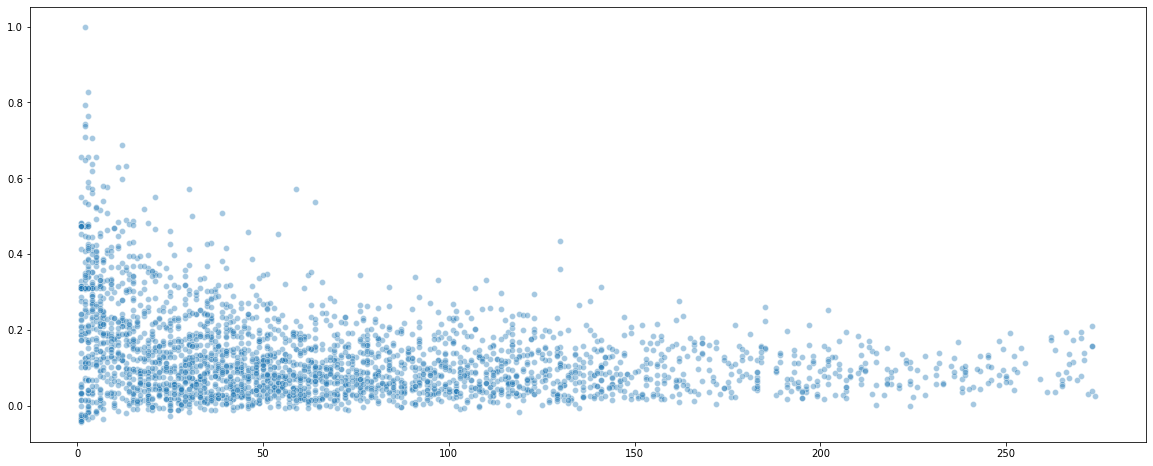

In [347]:
fst2 =fst[~is_outlier(n)]
n2 = n[~is_outlier(n)]

plt.figure(figsize=[20,8])
sns.scatterplot(n2,fst2, alpha=0.4)

In [350]:
geneswithsnpsidx = np.array(list(n_dict.keys())) #get indices of genes with snps
n_bool = n > 3 #get bool of genes that had more than 3 snps

topgenes_idx = largest_indices(fst[n_bool], 200)

fstgenes = genes.take(geneswithsnpsidx)
fstgenes = genes[_bool]
fstgenes = fstgenes.take(topgenes_idx[0])
fstgenes.shape

aegypti_names = pd.read_csv("../../resources/gene_names.tsv", sep="\t")
aegypti_names.columns = ['ID' if x=='Gene_stable_ID' else x for x in aegypti_names.columns]

fstresults = pd.merge(g3, aegypti_names).sort_values('start')

In [353]:
fstresults.head()

,seqid,source,type,start,end,score,strand,phase,ID,Gene_description,Gene_name
124,AaegL5_1,VEuPathDB,gene,3210543,3211340,-1,-,-1,AAEL023010,NaN,NaN
112,AaegL5_1,VEuPathDB,gene,4470247,4986550,-1,+,-1,AAEL009763,NaN,NaN
121,AaegL5_1,VEuPathDB,gene,8118192,8372076,-1,-,-1,AAEL000243,leucine-rich transmembrane protein [Source:VB ...,NaN
26,AaegL5_1,VEuPathDB,gene,8348256,8349445,-1,-,-1,AAEL029073,NaN,NaN
137,AaegL5_1,VEuPathDB,gene,9069975,9165711,-1,+,-1,AAEL025076,NaN,NaN
161,AaegL5_1,VEuPathDB,gene,11974122,12055966,-1,-,-1,AAEL002354,heme peroxidase [Source:VB Community Annotation],HPX5
114,AaegL5_1,VEuPathDB,gene,15218104,15219107,-1,+,-1,AAEL021530,NaN,NaN
25,AaegL5_1,VEuPathDB,gene,18203272,18416314,-1,-,-1,AAEL012718,Putative progestin and adipoq receptor family ...,NaN
60,AaegL5_1,VEuPathDB,gene,18765975,18770734,-1,+,-1,AAEL026743,NaN,NaN
71,AaegL5_1,VEuPathDB,gene,20933024,20934774,-1,-,-1,AAEL015586,NaN,NaN


For each gene, we want to get a boolean of the snps in that gene, compress the allele counts to that gene, then do average hudson fst for each gene.

## Calculating Fst in moving windows

In [38]:
size=100
step=50
fst = allel.moving_hudson_fst(sus_ac, res_ac, size=size, 
                                      step=step)
newpos = allel.moving_midpoint(pos, 
                               size=size, 
                               step=step)

In [39]:
na = np.isnan(fst)
fstval = fst[~na]
posval = newpos[~na]

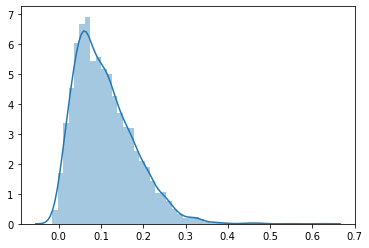

In [50]:
sns.distplot(fstval)

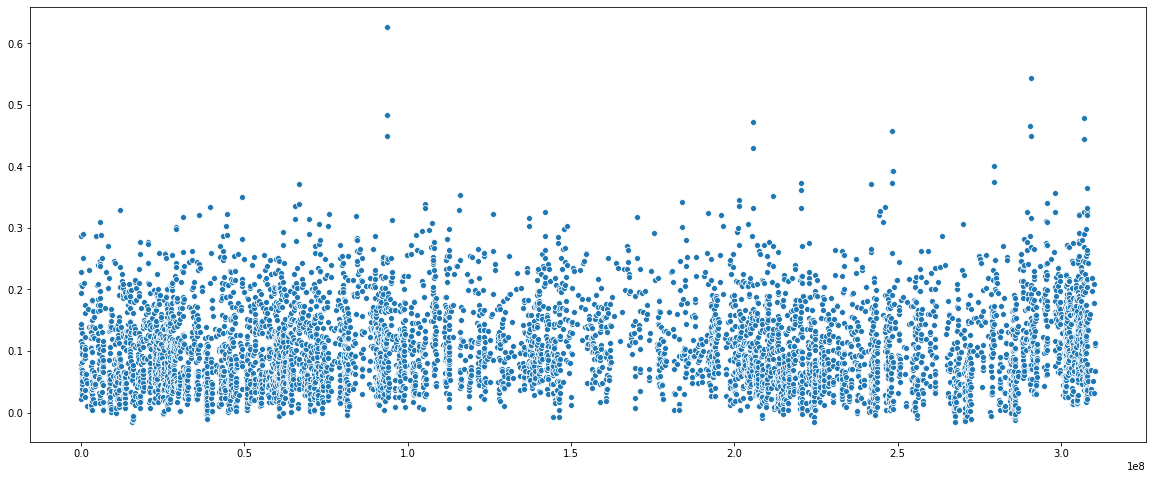

In [40]:
plt.figure(figsize=(20, 8))
sns.scatterplot(posval, fstval)

In [49]:
nsnps = len(fstval)*0.001
largfst = largest_indices(fstval, int(nsnps))
allel.SortedIndex(np.sort(newpos[largfst]))

0,1,2,3,4,5
93580820.0,93582174.0,205662419.0,290663610.5,290689309.5,307133790.5
